

**Machine Learning I (Semester 1 2025)**
# Tutorial Session 10: Unsupervised Learning & Dimensionality Reduction

*N. Hernitschek*



This Jupyter notebook is on the usage of unsupervised learning, including dimensionality reduction.

It is based on code from the textbook

*An Introduction to Statistical Learning: with Applications in Python.*
James Witten, Hastie, Tibshirani; Springer.

which is vailable for free as PDF: https://www.statlearning.com/

, as well as

Statistics, Data Mining and Machine Learning in Astronomy: A Practical Python Guide for the Analysis of
Survey Data - Z. Ivezic, A. J. Connolly, J. T. VanderPlas, A. Gray



***Exercises required for class participation are in <font color='red'>red</font>.***

---
## Contents
* [1. Dimensionality Reduction: Principal Component Analysis](#first-bullet)
* [2. Density Estimation: Kernel Density Estimation](#second-bullet)
* [3. Unsupervised Classification: Anomaly Detection](#third-bullet)





## 1. Dimensionality Reduction: Principal Component Analysis <a class="anchor" id="first-bullet"></a>


In Principal Component Analysis (PCA) we seek to take a data set and apply a transform to the data such that the new axes are aligned with the maximal variance of the data. 

As can be seen in the Figure below, this is basically just the same as doing *regression by minimizing the square of the perpendicular distances to the new axes*. Note that **we haven't made any changes to the data**, we have just defined new axes.  


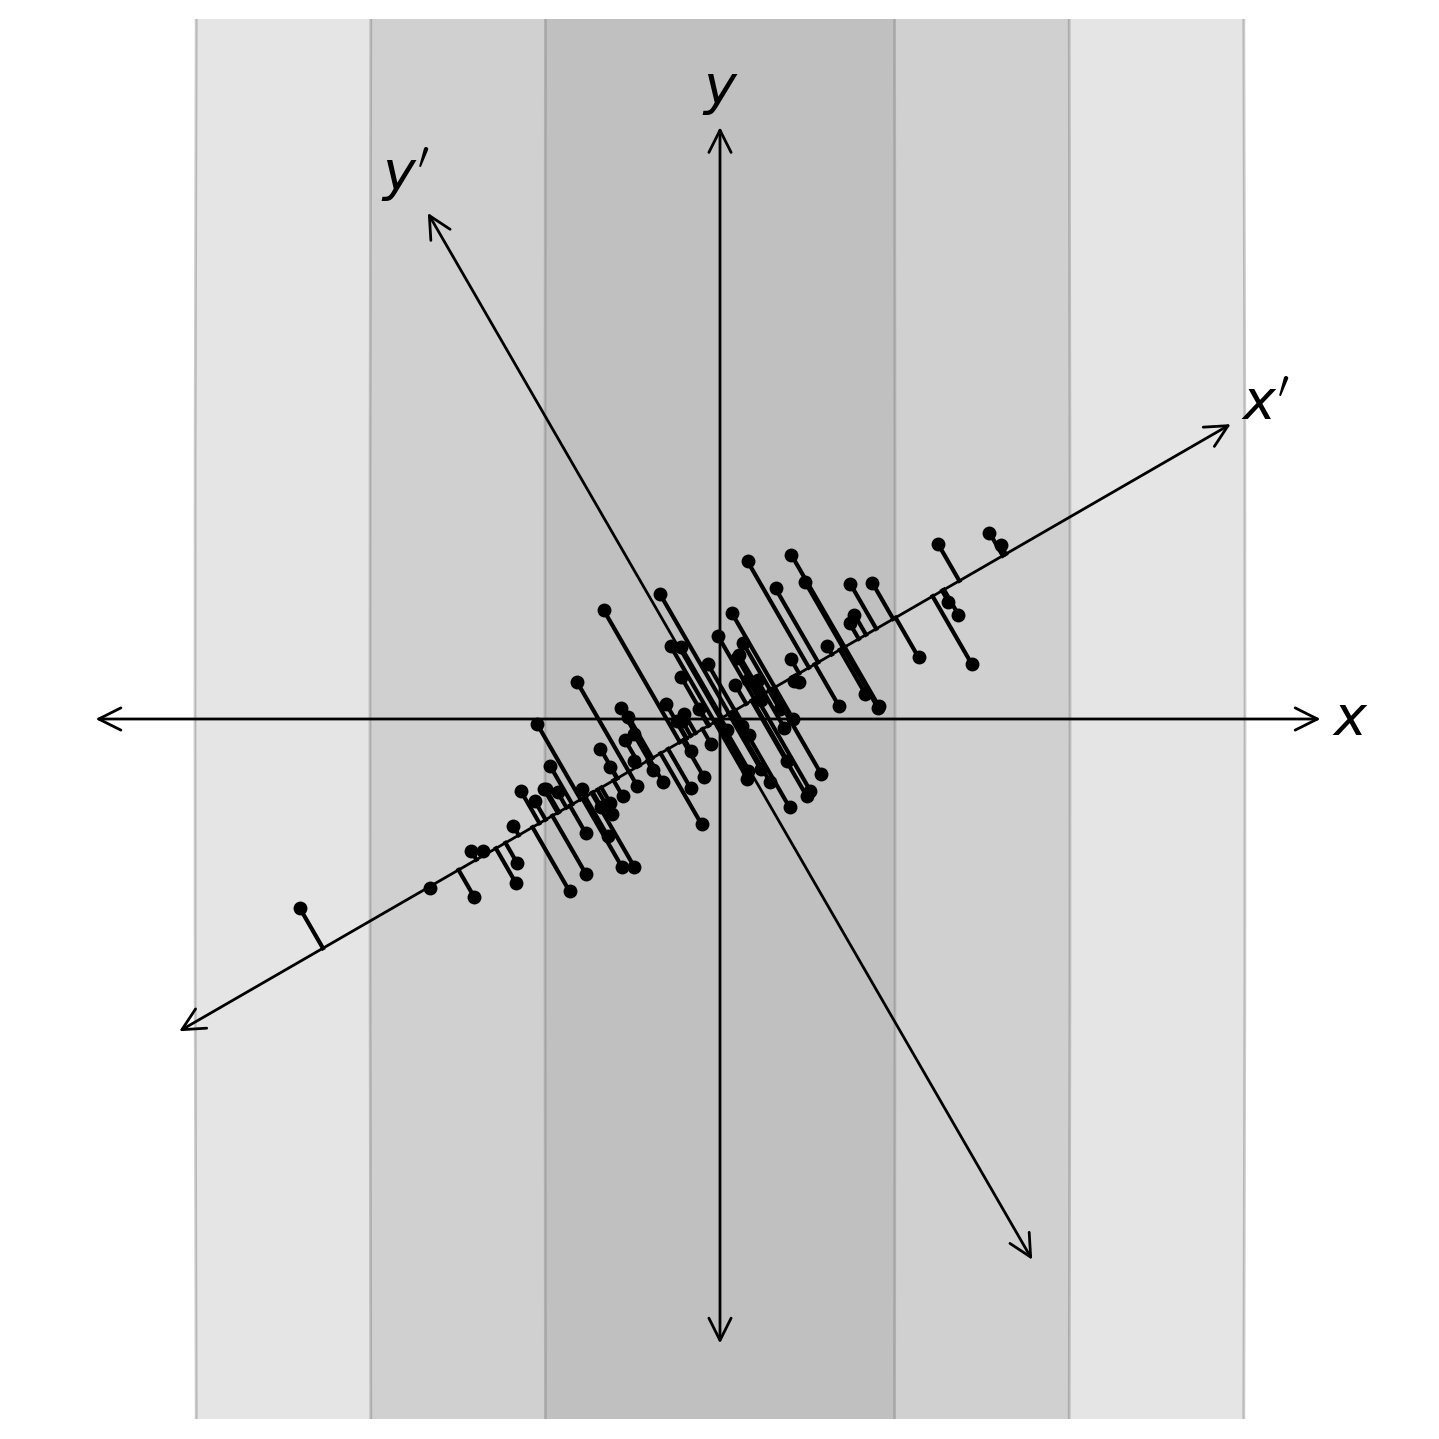

In [1]:

# Execute this cell
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'


# Ivezic, Figure 7.2
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
from matplotlib.patches import Ellipse

#------------------------------------------------------------
# Set parameters and draw the random sample
np.random.seed(42)
r = 0.9

sigma1 = 0.25
sigma2 = 0.08
rotation = np.pi / 6  #np.pi / 6
s = np.sin(rotation)
c = np.cos(rotation)

X = np.random.normal(0, [sigma1, sigma2], size=(100, 2)).T
R = np.array([[c, -s],[s, c]])
X = np.dot(R, X) #Same data, now rotated by R matrix.

#------------------------------------------------------------
# Plot the diagram
fig = plt.figure(figsize=(7, 7), facecolor='w')
ax = plt.axes((0, 0, 1, 1), xticks=[], yticks=[], frameon=False)

# draw axes
ax.annotate(r'$x$', (-r, 0), (r, 0),
            ha='center', va='center',fontsize=20,
            arrowprops=dict(arrowstyle='<->', 
                            color='k', lw=1))
ax.annotate(r'$y$', (0, -r), (0, r),
            ha='center', va='center',fontsize=20,
            arrowprops=dict(arrowstyle='<->', 
                            color='k', lw=1))

# draw rotated axes
ax.annotate(r'$x^\prime$', (-r * c, -r * s), (r * c, r * s),
            ha='center', va='center',fontsize=20,
            arrowprops=dict(color='k', 
                            arrowstyle='<->', 
                            lw=1))
ax.annotate(r'$y^\prime$', (r * s, -r * c), (-r * s, r * c),
            ha='center', va='center',fontsize=20,
            arrowprops=dict(color='k', 
                            arrowstyle='<->', 
                            lw=1))

# scatter points
ax.scatter(X[0], X[1], s=25, 
           lw=0, c='k', zorder=2)

# draw lines
vnorm = np.array([s, -c])
for v in (X.T):
    d = np.dot(v, vnorm)
    v1 = v - d * vnorm
    ax.plot([v[0], v1[0]], [v[1], v1[1]], '-k')

# draw ellipses
for sigma in (1, 2, 3):
    ax.add_patch(Ellipse((0, 0), 2 * sigma * sigma1, rotation * 180 / np.pi, ec='k', fc='gray', alpha=0.2, zorder=1))

ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)

plt.show()

Note that the points are correlated along a particular direction which doesn't align with the initial choice of axes. So, we should rotate our axes to align with this correlation. 

We'll choose the rotation to maximize the ability to discriminate between the data points:
*   the first axis, or **principal component**, is the direction of maximal variance
*   the second principal component is orthogonal to the first component and maximizes the residual variance
*   ...

**PCA is a dimensional reduction process because we can generally account for *nearly all* of the variance in the data set with fewer than the original $K$ dimensions.** See more below.

### Derivation of PCA

We start with a data set $\{x_i\}$ that consists of $N$ objects for which we measure $K$ features. The data is initially prepared by subtracting the mean for each feature in $\{x_i\}$ and writing $X$ as a $N\times K$ matrix.

The covariance of this matrix is the $K\times K$ matrix

$$C_X=\frac{1}{N-1}X^T X.$$

**There are off-diagonal terms if there are correlations between the measurements (e.g., maybe two of the features are temperature dependent and the measurements were taken at the same time).**


* If $R$ is a projection of the data that is aligned with the maximal variance, then we have $Y= X R$ with covariance 

$$ C_{Y} = R^T X^T X R = R^T C_X R.$$

* $r_1$ is the first principal component of $R$ (the first column) with the constraint $r_1^T r_1=1$. It can be derived using *Langrange multipliers* with the following cost function:

$$ \phi(r_1,\lambda_1) = r_1^TC_X r_1 - \lambda_1(r_1^Tr_1-1). $$

* If we take derivative of $\phi(r_1,\lambda)$ with respect to $r_1$ and set it to 0 (i.e., we extremize the cost function), then we have

$$ C_Xr_1 - \lambda_1 r_1 = 0. $$

* $\lambda_1$ (**the largest eigenvalue of the matrix**) is the root of the equation $\det(C_X -
\lambda_1 {\bf I})=0$ for which the eigenvalue is

$$ \lambda_1 =  r_1^T C_X r_1.$$

* The columns of the full matrix, $R$ are the **eigenvectors (known here as principal components)**.

* The diagonal values of $C_Y$ are the variance contained within each component.

A more detailed description can be found in the book in section 7.3.1.

### Preparing data for PCA

1. Subtract the mean of each dimension/feature/column (to **"center"** the data)
2. Divide by the variance in each dimension/feature/column (to **"whiten"** the data)
3. (For spectra and images) normalize each sample/row to yield an integral of unity.

Below is a typical call to the PCA algorithm.  Note that this example is somewhat backwards.  We are starting with `X` and then we are making it higher dimensional--to create a mock high-$D$ data set.  Then we are applying PCA as a dimensionality reduction technique.

In [2]:
#Example call from 7.3.2
import numpy as np
from sklearn.decomposition import PCA

X = np.random.normal(size=(100,3)) # 100 points in 3D
R = np.random.random((3,10)) # projection matrix
X = np.dot(X,R) # X is now 10-dim, with 3 intrinsic dims

pca = PCA(n_components=4) # n_components can be optionally set
pca.fit(X) 

eigenvalues = pca.transform(X) # compute the subspace projection of X, 4 eigenvalues for each of the 100 samples
mean = pca.mean_ # length 10 mean of the data
eigenvectors = pca.components_ # 4x10 matrix of components, multiply each by respective eigenvalue to reconstruct

# Reconstruction of object1
# Xreconstruct[0] = mean + eigenvectors*eigenvalues[0]

print(eigenvalues.shape)
print(eigenvectors.shape)

(100, 4)
(4, 10)


[Scikit-Learn's decomposition module](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.decomposition) has a number of [PCA type implementations](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA).


In the following, we see a detailed example using spectra of galaxies taken during the Sloan Digital Sky Survey (SDSS).  

In this sample there are 4000 spectra with flux measurements in 1000 bins.  15 example spectra are shown below and our example will use half of the spectra chosen at random.  

![Ivezic, Figure 7.1](http://www.astroml.org/_images/fig_spec_examples_1.png)

In [3]:
# Example from Andy Connolly
# See Ivezic, Figure 7.4

from sklearn.decomposition import PCA
#from sklearn.decomposition import RandomizedPCA

from astroML.datasets import sdss_corrected_spectra
from astroML.utils import pickle_results

#------------------------------------------------------------
# Download data
data = sdss_corrected_spectra.fetch_sdss_corrected_spectra()
spectra = sdss_corrected_spectra.reconstruct_spectra(data)
wavelengths = sdss_corrected_spectra.compute_wavelengths(data)
print('Number of spectra: ' + str(len(spectra)))
print('Number of wavelength bins: ' + str(len(wavelengths)))

#----------------------------------------------------------------------
# Compute PCA
np.random.seed(500)
nrows = 2000 # We'll just look at 2000 random spectra
n_components = 5 # Do the fit with 5 components, which is the mean plus 4
ind = np.random.randint(spectra.shape[0], size=nrows)

spec_mean = spectra[ind].mean(0) # Compute the mean spectrum, which is the first component
# spec_mean = spectra[:50].mean(0)

# use Randomized PCA for speed
# pca = RandomizedPCA(n_components - 1)
pca = PCA(n_components - 1, svd_solver='randomized')
pca.fit(spectra[ind])
pca_comp = np.vstack([spec_mean, pca.components_]) # Add the mean to the components
evals = pca.explained_variance_ratio_ 
print('Expained fractional variance of data encapsulated in the eigenvalues: ' + str(evals))

Number of spectra: 4000
Number of wavelength bins: 1000
Expained fractional variance of data encapsulated in the eigenvalues: [0.8893161  0.060583   0.02481432 0.01012148]


**Now let's plot the components (eigenvectors).** The left hand panels are just the *first 5 spectra for comparison* with the *first 5 PCA components*, which are shown on the right.  They are ordered by the size of their eigenvalues.

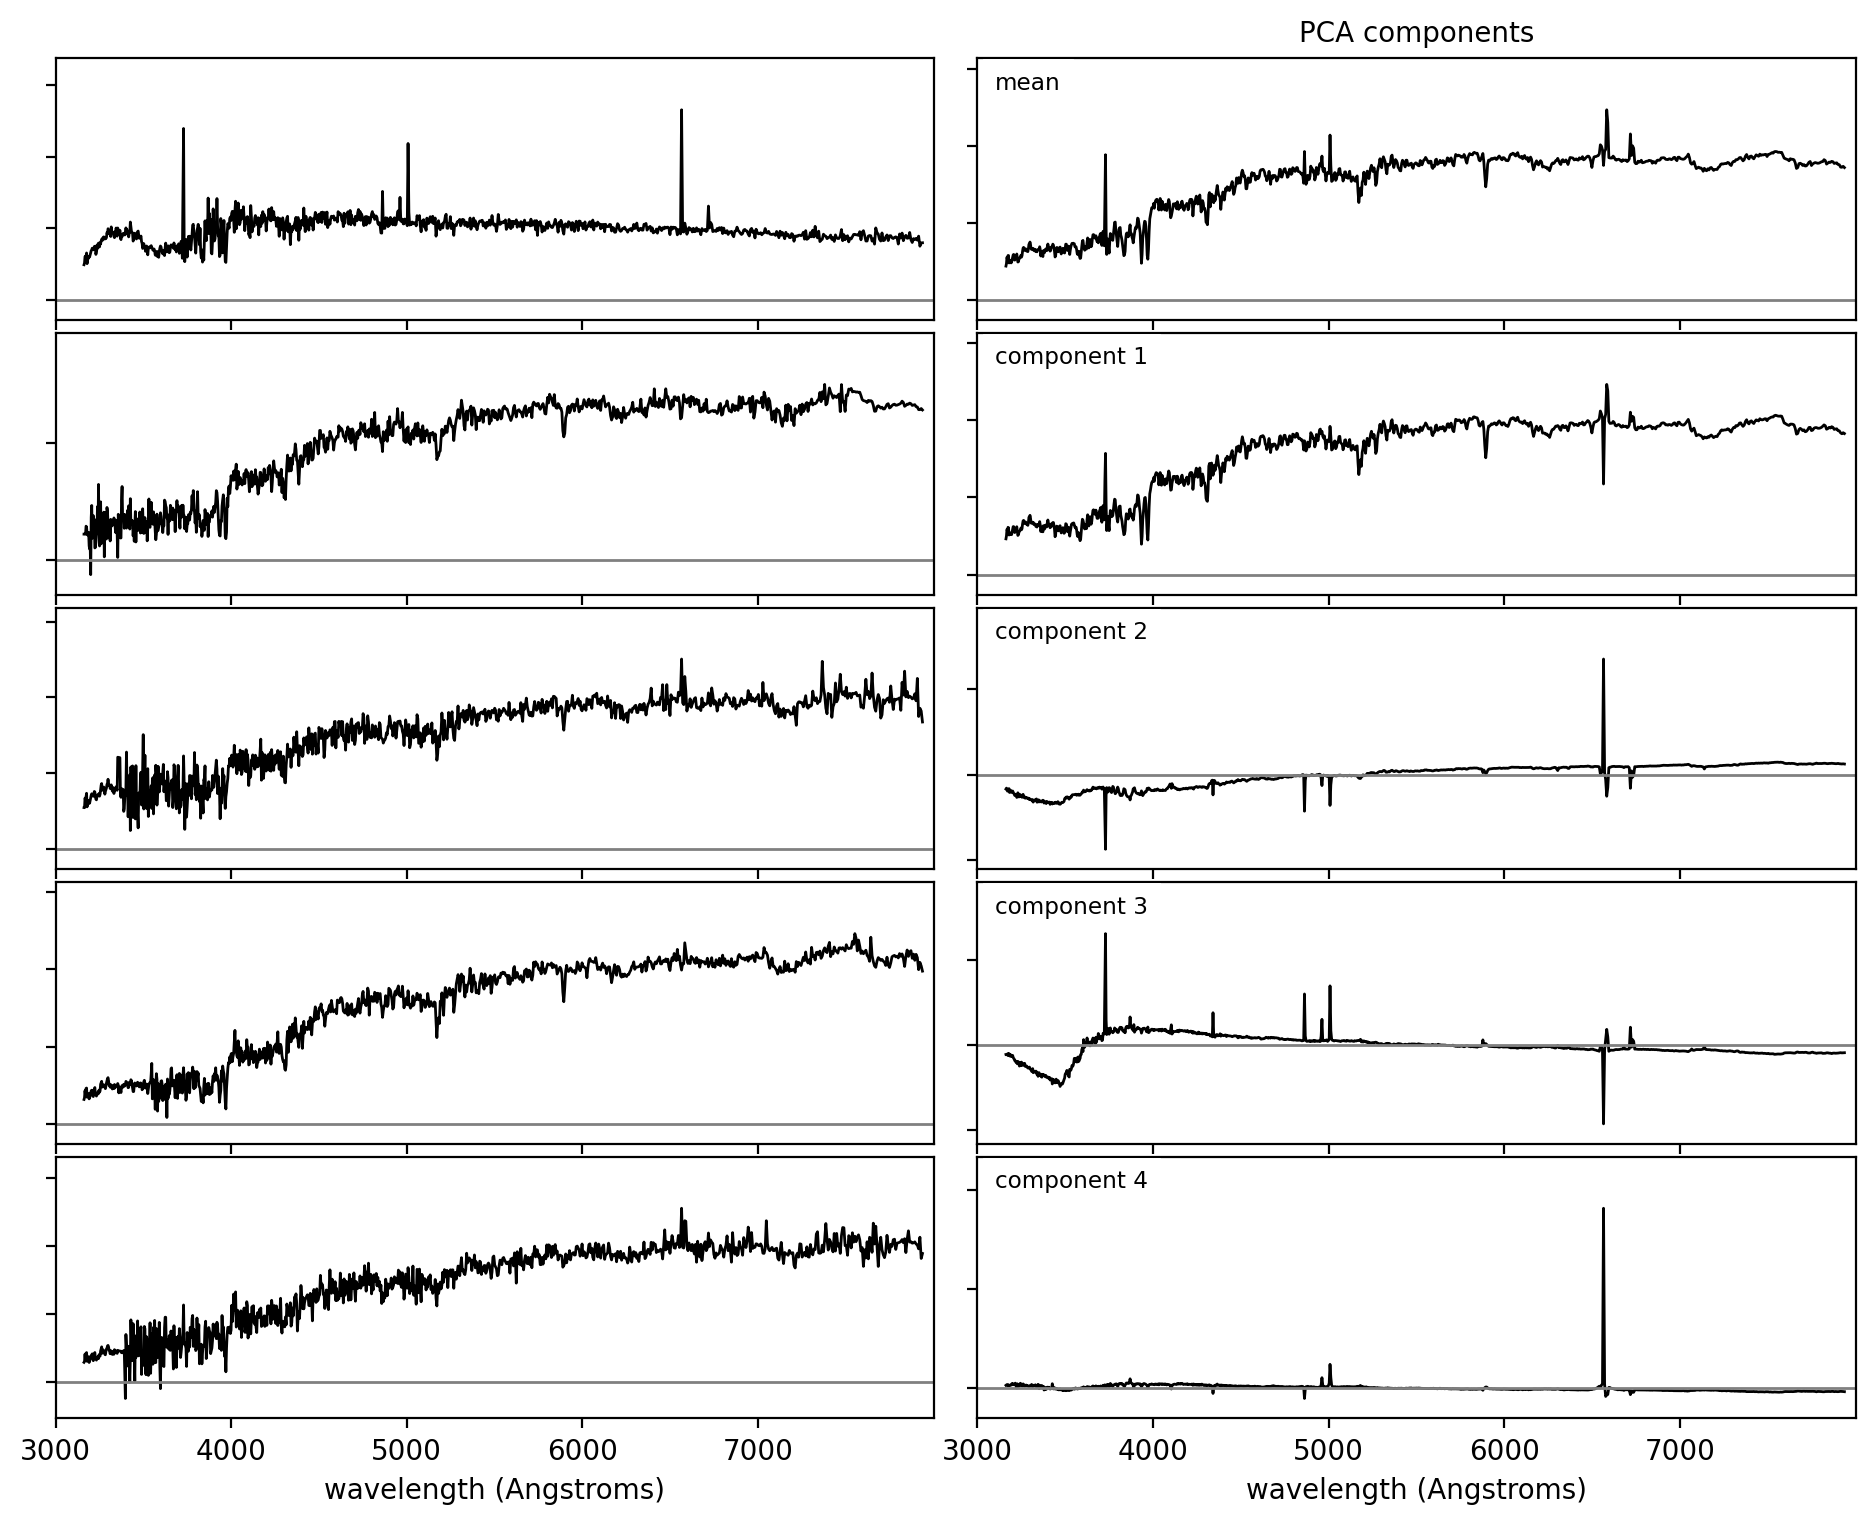

In [4]:
# Make plots
fig = plt.figure(figsize=(10, 8))
fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05,
                    bottom=0.1, top=0.95, hspace=0.05)

titles = 'PCA components'

for j in range(n_components):
    
    # plot the components
    ax = fig.add_subplot(n_components, 2, 2*j+2)
    ax.yaxis.set_major_formatter(plt.NullFormatter())
    ax.xaxis.set_major_locator(plt.MultipleLocator(1000))
    
    if j < n_components - 1:
        ax.xaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax.set_xlabel('wavelength (Angstroms)')
    ax.plot(wavelengths, pca_comp[j], '-k', lw=1)

    # plot zero line
    xlim = [3000, 7999]
    ax.plot(xlim, [0, 0], '-', c='gray', lw=1)
    ax.set_xlim(xlim)

    # adjust y limits
    ylim = plt.ylim()
    dy = 0.05 * (ylim[1] - ylim[0])    
    ax.set_ylim(ylim[0] - dy, ylim[1] + 4 * dy)

    # plot the first j spectra
    ax2 = fig.add_subplot(n_components, 2, 2*j+1)
    ax2.yaxis.set_major_formatter(plt.NullFormatter())
    ax2.xaxis.set_major_locator(plt.MultipleLocator(1000))
    if j < n_components - 1:
        ax2.xaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax2.set_xlabel('wavelength (Angstroms)')
    ax2.plot(wavelengths, spectra[j], '-k', lw=1)
    
    # plot zero line
    ax2.plot(xlim, [0, 0], '-', c='gray', lw=1)
    ax2.set_xlim(xlim)

    if j == 0:
        ax.set_title(titles, fontsize='medium')
    if j == 0:
        label = 'mean'
    else:
        label = 'component %i' % j

    # adjust y limits
    ylim = plt.ylim()
    dy = 0.05 * (ylim[1] - ylim[0])    
    ax2.set_ylim(ylim[0] - dy, ylim[1] + 4 * dy)

    ax.text(0.02, 0.95, label, transform=ax.transAxes,
            ha='left', va='top', bbox=dict(ec='w', fc='w'),
            fontsize='small')

plt.show()

Now let's make **scree plots**.  These plots tell us how much of the variance is explained as a function of the each eigenvector. 

[0 1 2 3]
[0.8893161  0.9498991  0.9747134  0.98483485]


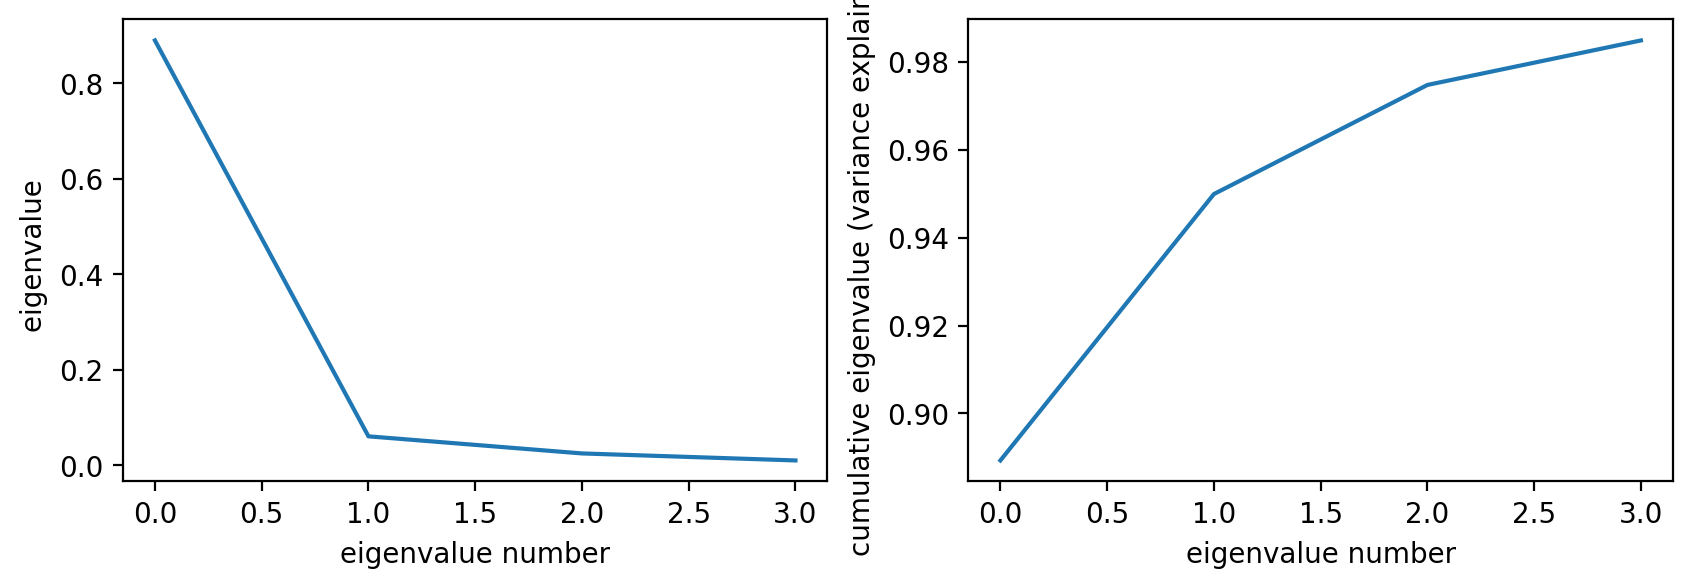

In [5]:
# Execute this cell
import numpy as np
from matplotlib import pyplot as plt

#----------------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(10, 3))

ax = fig.add_subplot(121)
ax.plot(np.arange(n_components-1), evals)
ax.set_xlabel("eigenvalue number")
ax.set_ylabel("eigenvalue ")

ax = fig.add_subplot(122)
ax.plot(np.arange(n_components-1), evals.cumsum())
ax.set_xlabel("eigenvalue number")
ax.set_ylabel("cumulative eigenvalue (variance explained)")

print(np.arange(n_components-1))
print(evals.cumsum())

plt.show()

<font color='red'>How much of the variance is explained ([explained_variance_ratio_](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)) by the first two components?  How about all of the components?</font>

94.99% of the total variance is explained by the first two component,  98.48% of the variance is explained by all four components

## 2. Density Estimation: Kernel Density Estimation <a class="anchor" id="second-bullet"></a>

Inferring the pdf of a sample of data is known as ***density estimation***. Essentially we are smoothing the data to correct for the finiteness of our sample and to better recover the underlying distribution.

Density estimation is useful because:
- identifying low probability regions can help uncover rare sources. 
- if the data can be divided into sub-samples, one can estimate the pdf for each subsample and, in turn determine classifications for new objects.

### Non-parametric Density Estimation <a class="anchor" id="onea"></a>

*Nonparametric* density estimation is useful when we know nothing about the underlying distribution of the data, since we don't have to specify a functional form. This flexibility allows us to capture the shape of the distribution well, at the expense of more difficulty interpreting the results.

#### Kernel Density Estimation (KDE)

[*Kernel Density Estimation (KDE)*](https://en.wikipedia.org/wiki/Kernel_density_estimation) is the standard approach for non-parametric density estimation.

Let's start by recalling some problems with making simple histograms.

In [11]:
# Execute this cell
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [12]:
#------------------------------------------------------------
# Draw some random data
np.random.seed(1)
x = np.concatenate([np.random.normal(-0.5, 0.3, size=14), 
                    np.random.normal(1, 0.3, size=7)])

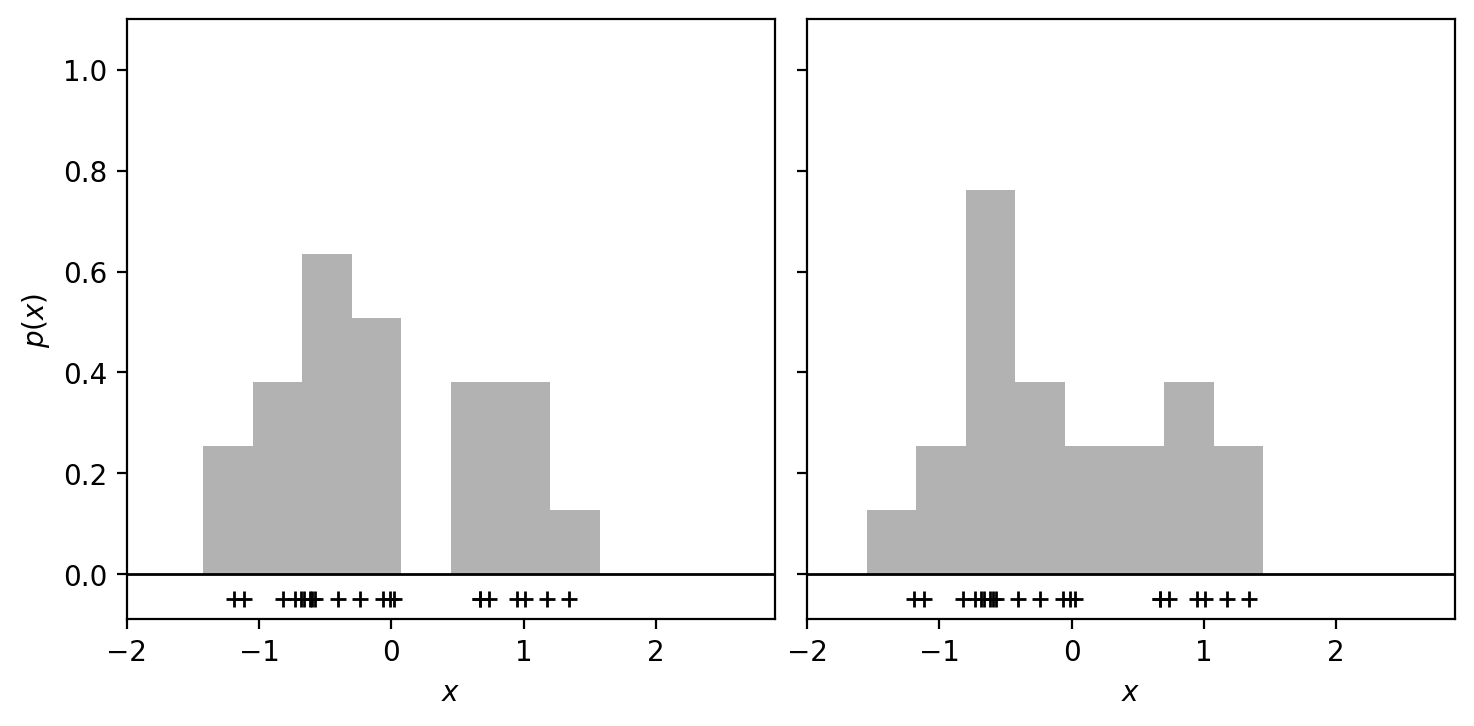

In [13]:

# Modified from Ivezic, Figure 6.1, modified by GTR
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
#------------------------------------------------------------

# First figure: silly histogram binning
fig1 = plt.figure(figsize=(8, 4))
fig1.subplots_adjust(left=0.12, right=0.95, wspace=0.05, 
                     bottom=0.15, top=0.9, hspace=0.05)

FC = '#6666FF'
XLIM = (-2, 2.9)
YLIM = (-0.09, 1.1)

ax = fig1.add_subplot(121)
bins = np.linspace(-1.8, 2.7, 13)
ax.hist(x, bins=bins, density=True, 
        histtype='stepfilled', fc='k', alpha=0.3)
ax.plot(XLIM, [0, 0], '-k', lw=1)
ax.plot(x, 0 * x - 0.05, '+k')
ax.set_xlim(XLIM)
ax.set_ylim(YLIM)
ax.set_xlabel('$x$')
ax.set_ylabel('$p(x)$')

#Shift bin centers by 0.25
ax = fig1.add_subplot(122)
ax.yaxis.set_major_formatter(plt.NullFormatter())
ax.hist(x, bins=bins + 0.25, density=True, 
        histtype='stepfilled', fc='k', alpha=0.3)
ax.plot(XLIM, [0, 0], '-k', lw=1)
ax.plot(x, 0 * x - 0.05, '+k')
ax.set_xlim(XLIM)
ax.set_ylim(YLIM)
ax.set_xlabel('$x$')

plt.show()

The data points that make up the histogram are the same in both panels.  All we have done is shifted the locations of the bins by 0.25. ***The choice of number of bins and the location of bin centers can really change the histogram that we make.***

The next panels are what happens if we center the bins on each point. This is an example of **kernel density estimation** using a "***top-hat***" kernel. It is a good description of the data, but pretty ugly.

Text(0, 0.5, '$p(x)$')

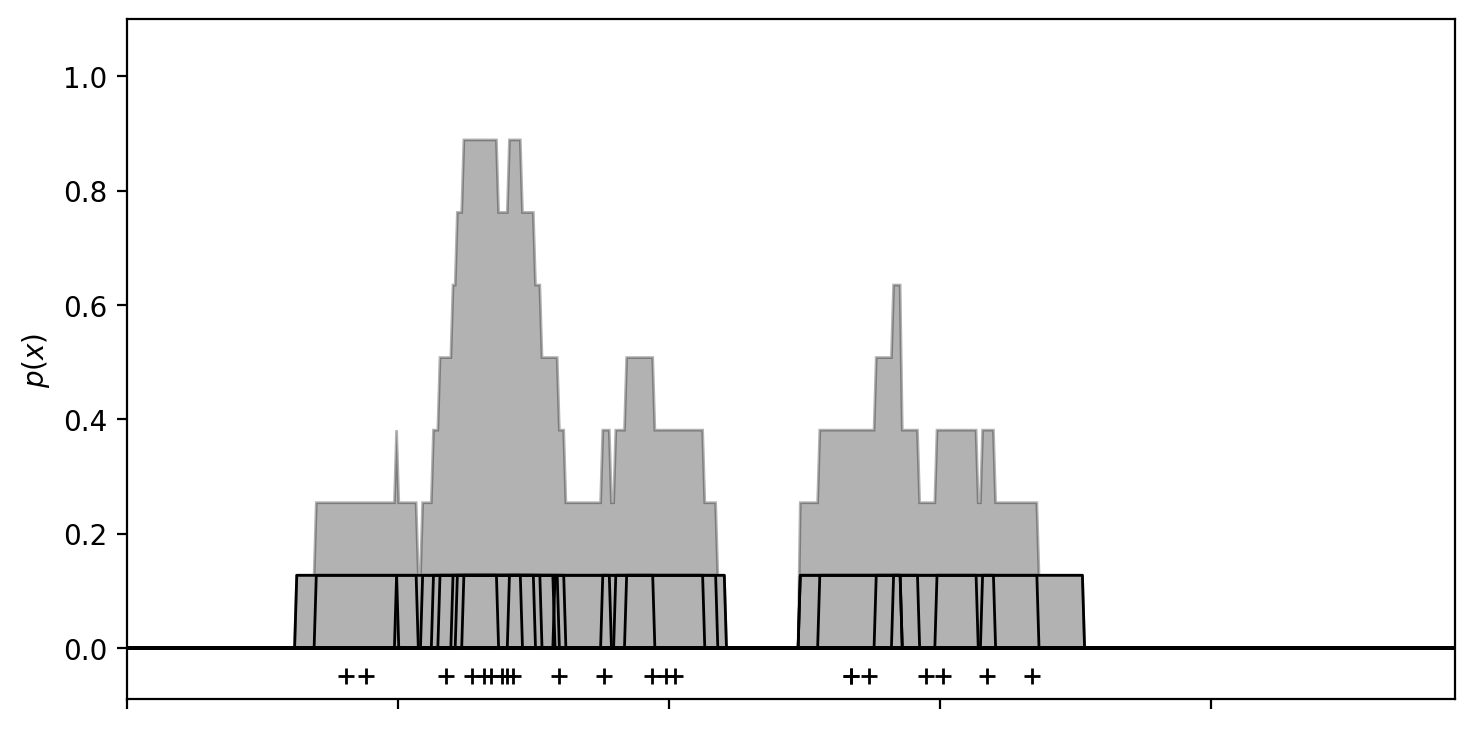

In [14]:
fig1b = plt.figure(figsize=(8, 4))
fig1b.subplots_adjust(left=0.12, right=0.95, wspace=0.05, 
                      bottom=0.1, top=0.95, hspace=0.05)

ax = fig1b.add_subplot(111)
ax.xaxis.set_major_formatter(plt.NullFormatter())
binwidth = bins[1] - bins[0]
x_plot = np.linspace(-4, 4, 1000)
y_plot = (abs(x_plot - x[:, None]) <= 0.5 * binwidth).astype(float)
y_plot /= (binwidth * len(x))
ax.fill(x_plot, y_plot.sum(0), ec='k', lw=1, fc='k', alpha=0.3)
ax.plot(x_plot, y_plot.T, '-k', lw=1)
ax.plot(x, 0 * x - 0.05, '+k')
ax.set_xlim(XLIM)
ax.set_ylim(YLIM)
ax.set_ylabel('$p(x)$')

<font color='red'>We can make it look nicer by choosing a different kernel, i.e. a different bin shape. 
Try out using a Gaussian kernel.
</font>



### Gaussian Kernel

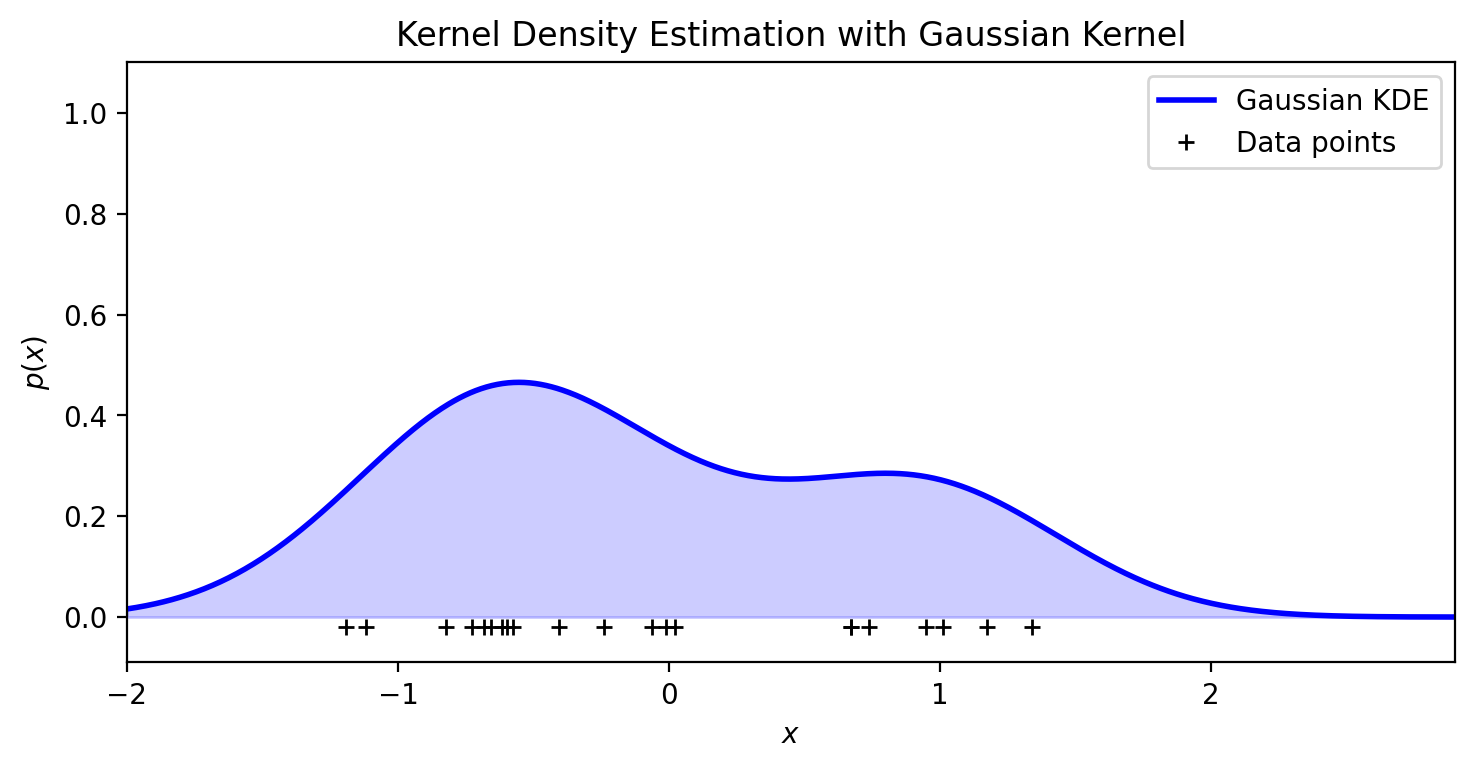

In [15]:
# Gaussian Kernel Density Estimate
fig2 = plt.figure(figsize=(8, 4))
fig2.subplots_adjust(left=0.12, right=0.95, bottom=0.15, top=0.9)

ax = fig2.add_subplot(111)

# Define evaluation points
x_eval = np.linspace(-2, 3, 1000)

# Perform Gaussian KDE
kde = stats.gaussian_kde(x)
y_kde = kde(x_eval)

# Plot results
ax.plot(x_eval, y_kde, color='blue', lw=2, label='Gaussian KDE')
ax.fill_between(x_eval, y_kde, color='blue', alpha=0.2)
ax.plot(x, 0 * x - 0.02, '+k', label='Data points')

ax.set_xlim(XLIM)
ax.set_ylim(YLIM)
ax.set_xlabel('$x$')
ax.set_ylabel('$p(x)$')
ax.set_title('Kernel Density Estimation with Gaussian Kernel')
ax.legend()

plt.show()


## 3. Unsupervised Classification: Anomaly Detection <a class="anchor" id="first-bullet"></a>
One efficient way of performing outlier detection in high-dimensional datasets is to use random forests. The *isolation forest* implementation ensemble.IsolationForest ‘isolates’ observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.

Since recursive partitioning can be represented by a tree structure, the number of splittings required to isolate a sample is equivalent to the path length from the root node to the terminating node.

This path length, averaged over a forest of such random trees, is a measure of normality and our decision function.

Random partitioning produces noticeably shorter paths for anomalies. Hence, when a forest of random trees collectively produce shorter path lengths for particular samples, they are highly likely to be anomalies.

The implementation of ensemble.IsolationForest is based on an ensemble of tree.ExtraTreeRegressor. Following Isolation Forest original paper, the maximum depth of each tree is set to $ \lceil log_2(n) \rceil$
where $n$ is the number of samples used to build the tree (see (Liu et al., 2008) for more details).

*References:* Liu, Fei Tony, Ting, Kai Ming and Zhou, Zhi-Hua. “Isolation forest.” Data Mining, 2008. ICDM’08. Eighth IEEE International Conference on.

The usage of this algorithm as implemented in `scikit-learn` is illustrated below.


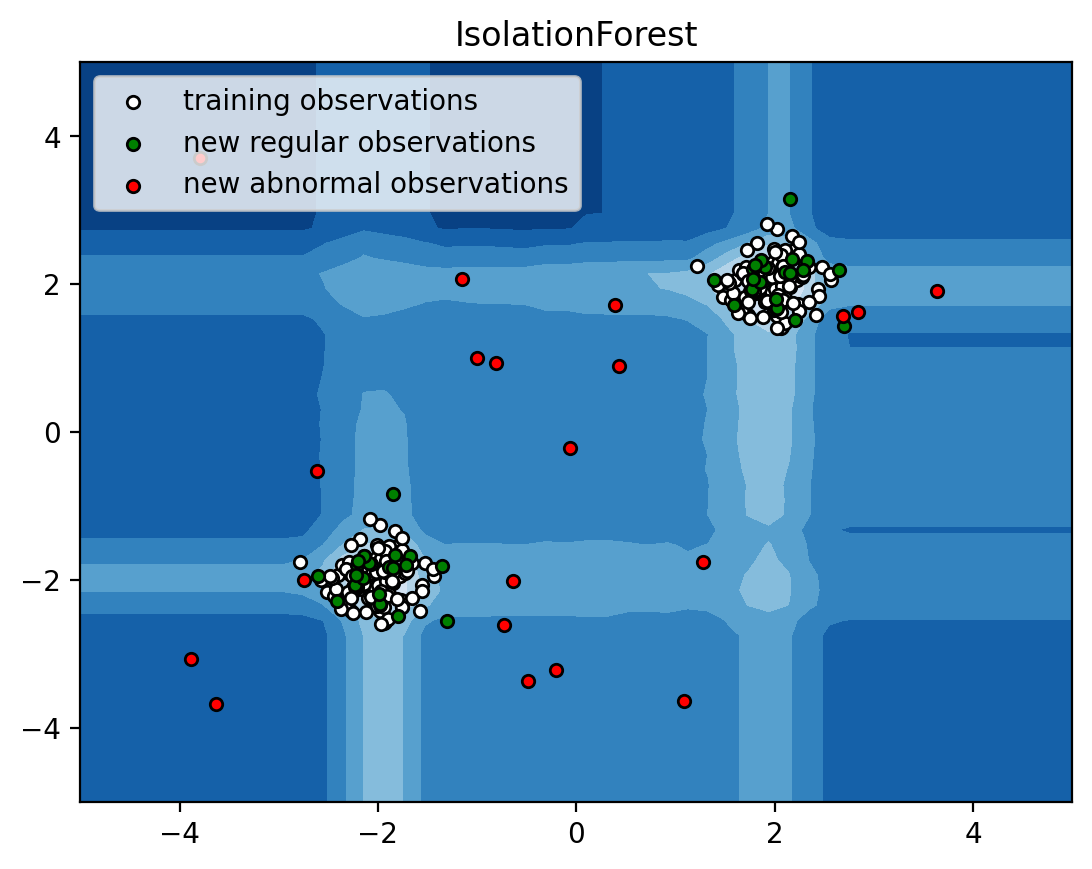

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

rng = np.random.RandomState(42)

# Generate train data
X = 0.3 * rng.randn(100, 2)
X_train = np.r_[X + 2, X - 2]
# Generate some regular novel observations
X = 0.3 * rng.randn(20, 2)
X_test = np.r_[X + 2, X - 2]
# Generate some abnormal novel observations
X_outliers = rng.uniform(low=-4, high=4, size=(20, 2))

# fit the model
clf = IsolationForest(max_samples=100, random_state=rng)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)

# plot the line, the samples, and the nearest vectors to the plane
xx, yy = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.title("IsolationForest")
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c="white", s=20, edgecolor="k")
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c="green", s=20, edgecolor="k")
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c="red", s=20, edgecolor="k")
plt.axis("tight")
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend(
    [b1, b2, c],
    ["training observations", "new regular observations", "new abnormal observations"],
    loc="upper left",
)
plt.show()

## Summary <a class="anchor" id="fourth-bullet"></a>

At this point, all of you should have:
* seen how to use PCA for dimensionality reduction
* seen KDE as an example for nonparametric density estimation
* applied the more advanced method of Isolation Forest
and understand its usage.